# Important notice

***This notebook can only be run on the Loihi cloud at the moment.***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import logging

from lava.magma.core.run_configs import Loihi2HwCfg, Loihi2SimCfg
from lava.magma.core.run_conditions import RunSteps
from lava.proc import io
from lava.lib.dl import netx
from lava.lib.dl import slayer
from lava.utils.system import Loihi2

from utils import InputAdapter, OutputAdapter

# Import modules for Loihi2 execution

Check if Loihi2 compiker is available and import related modules.

In [2]:
Loihi2.preferred_partition = 'oheogulch'
loihi2_is_available = Loihi2.is_loihi2_available

if loihi2_is_available:
    from lava.proc import embedded_io as eio
    from lava.utils import loihi2_profiler
    print(f'Running on {Loihi2.partition}')
else:
    print("Loihi 2 not available -> running on CPU")

Running on oheogulch


## Create network block

* The input layer is accessible as `net.in_layer`.
* The output layer is accessible as `net.out_layer`.
* All the constituent layers are accessible as a list: `net.layers`.

In [3]:
net = netx.hdf5.Network(net_config='network_dvs_nodelay_49.net')
print(net)

	RESOLUTION: truncate to min_weight=-256, max_weight=254
|   Type   |  W  |  H  |  C  | ker | str | pad | dil | grp |delay|
|Dense     |    1|    1|  512|     |     |     |     |     |True |
|Dense     |    1|    1|  512|     |     |     |     |     |True |
|Dense     |    1|    1|    2|     |     |     |     |     |False|


In [4]:
print(f'There are {len(net)} layers in the network:')

for l in net.layers:
    print(f'{l.block:5s} : {l.name:10s}, shape : {l.shape}')

There are 3 layers in the network:
Dense : Process_1 , shape : (512,)
Dense : Process_4 , shape : (512,)
Dense : Process_7 , shape : (2,)


Make sure all weight matrices are non-zero (issue #170 on lava-dl repo)

In [5]:
for i in range(3):
    print(net.layers[i].synapse.weights.init.sum(), end=' ')

-6872730 -1392060 560 

## Create Spike Input/Ouptut process

Here, we will use `RingBuffer` processes in `lava.proc.io.{source/sink}` to generate spike that is sent to the network and record the spike output from the network.

In [6]:
num_steps = 1000

In [7]:
inp = np.load('input_dvs_a1_0.npy').squeeze() # squeeze batch_dim
print('input of shape:', inp.shape)
source = io.source.RingBuffer(data=inp)
sink = io.sink.RingBuffer(shape=net.out.shape, buffer=num_steps)

inp_adapter = InputAdapter(shape=net.inp.shape)
out_adapter = OutputAdapter(shape=net.out.shape)

source.s_out.connect(inp_adapter.inp)
inp_adapter.out.connect(net.inp)
net.out.connect(out_adapter.inp)
out_adapter.out.connect(sink.a_in)

input of shape: (1536, 1000)


## Configure profiling tools

In [8]:
power_logger = loihi2_profiler.Loihi2Power(num_steps=num_steps)
runtime_logger = loihi2_profiler.Loihi2ExecutionTime()
memory_logger = loihi2_profiler.Loihi2Memory()
activity_logger = loihi2_profiler.Loihi2Activity()
callback_fxs = [power_logger, runtime_logger, memory_logger, activity_logger]

## Run the network

We will run the network for `num_steps` steps and read the network's output.

Switching between Loihi 2 hardware and CPU simulation is as simple as changing the run configuration settings.

In [9]:
if loihi2_is_available:
    from utils import CustomHwRunConfig
    run_config = CustomHwRunConfig(callback_fxs=callback_fxs)
else:
    from utils import CustomSimRunConfig
    run_config = CustomSimRunConfig()
run_condition = RunSteps(num_steps=num_steps)
net._log_config.level = logging.INFO
net.run(condition=run_condition, run_cfg=run_config)
output = sink.data.get()
net.stop()

Violation core_id=1 reg_name='SynMem' allocation=82432 self.cost_db.registers[reg_name]=12000
Violation core_id=2 reg_name='SynMem' allocation=247296 self.cost_db.registers[reg_name]=12000
Final max_ratio=7, Violation core_id=1 reg_name='SynMem' allocation=82432 self.cost_db.registers[reg_name]=12000
Final max_ratio=21, Violation core_id=2 reg_name='SynMem' allocation=95232 self.cost_db.registers[reg_name]=12000
Final max_ratio=7, Violation core_id=1 reg_name='SynMem' allocation=13824 self.cost_db.registers[reg_name]=12000
Final max_ratio=8, Violation core_id=8 reg_name='SynMem' allocation=12288 self.cost_db.registers[reg_name]=12000
Final max_ratio=2, Per core distribution:
----------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Cores |
|--------------------------------------------------------------|
|     512|       1|       2|     512|       2|       0|       1|
|     512|       1|      39|    6419|      39|       0| 

Make sure the output spiked, and that the right class spiked:

In [10]:
print(output.shape, output.sum(axis=1))

(2, 1000) [194.   9.]


## Plot the results
Finally, convert output spike data into an event and plot them.

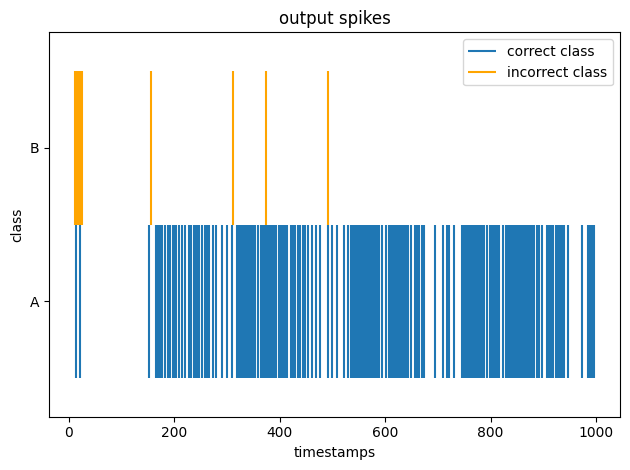

In [11]:
plt.title('output spikes')
plt.ylabel('class')
plt.xlabel('timestamps')
plt.eventplot(np.where(output[0] == 1.0), label='correct class', lineoffset=0)
plt.eventplot(np.where(output[1] == 1.0), label='incorrect class', color='orange')
plt.yticks([1, 0], ['B', 'A'])
plt.legend()
plt.ylim(-0.75,1.75)
plt.tight_layout();

# Profiling

## Time results

In [12]:
avg_time_per_step = runtime_logger.avg_time_per_step / 1e6
print(f'average time per step: {avg_time_per_step:.3f}s, '
      f'total time: {num_steps * avg_time_per_step:.3f}s')

average time per step: 0.084s, total time: 83.882s


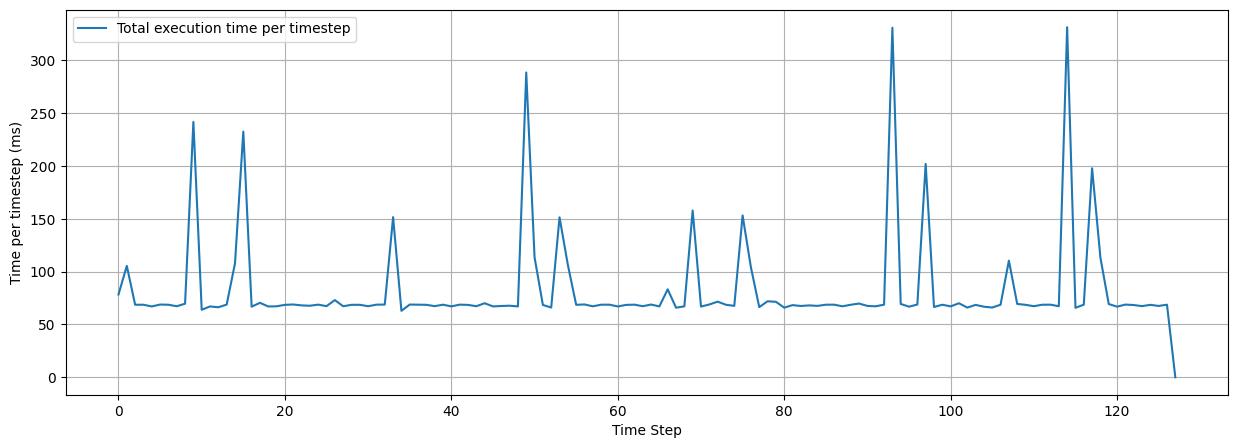

In [13]:
plt.figure(figsize=(15, 5))
plt.plot(runtime_logger.execution_time_per_step / 1e3, label='Total execution time per timestep')
plt.xlabel('Time Step')
plt.ylabel('Time per timestep (ms)')
plt.grid()
plt.legend();

## Power Results

The power profiler measures the power used by the Loihi system. It provies the individual measurements used by the 
* Loihi 2 neurocore circuits (`vdd_power`)
* Loihi 2 memory circuits (`vddm_power`)
* Loihi 2 input-output pheripherial circuits (`vddio_power`)

along with the total power (`total_power`). It also measures the static power of system when the system is idle.

In [14]:
vdd_p = power_logger.vdd_power  # neurocore power
vddm_p = power_logger.vddm_power  # memory power
vddio_p = power_logger.vddio_power  # IO power
total_power = power_logger.total_power

### Compensate for the idle chips on the board

The power measurement is done at a entire board level. PilotNet LIF runs on a single chip. So the static power consumed by the remaining Loihi 2 chips on the board need to be compensated.

In [15]:
num_chips = 1
if Loihi2.partition in ['kp', 'kp_stack', 'kp_build']:
    num_chips = 8

# per chip static power
static_total_power = power_logger.static_total_power / num_chips
static_vdd_p = power_logger.static_vdd_power / num_chips
static_vddm_p = power_logger.static_vddm_power / num_chips
static_vddio_p = power_logger.static_vddio_power / num_chips

# compensate for static power of multiple chip
total_power -= (num_chips - 1) * static_total_power
vdd_p -= (num_chips - 1) * static_vdd_p
vddm_p -= (num_chips - 1) * static_vddm_p
vddio_p -= (num_chips - 1) * static_vddio_p

In [16]:
total_power_mean = np.mean(total_power)
vdd_p_mean = np.mean(vdd_p)
vddm_p_mean = np.mean(vddm_p)
vddio_p_mean = np.mean(vddio_p)
print(f'Total Power   : {total_power_mean:.6f} W')
print(f'Dynamic Power : {total_power_mean - static_total_power:.6f} W')
print(f'Static Power  : {static_total_power:.6f} W')
print(f'VDD Power     : {vdd_p_mean:.6f} W')
print(f'VDD-M Power   : {vddm_p_mean:.6f} W')
print(f'VDD-IO Power  : {vddio_p_mean:.6f} W')

Total Power   : 0.546608 W
Dynamic Power : -0.000346 W
Static Power  : 0.546954 W
VDD Power     : 0.192165 W
VDD-M Power   : 0.297328 W
VDD-IO Power  : 0.057115 W


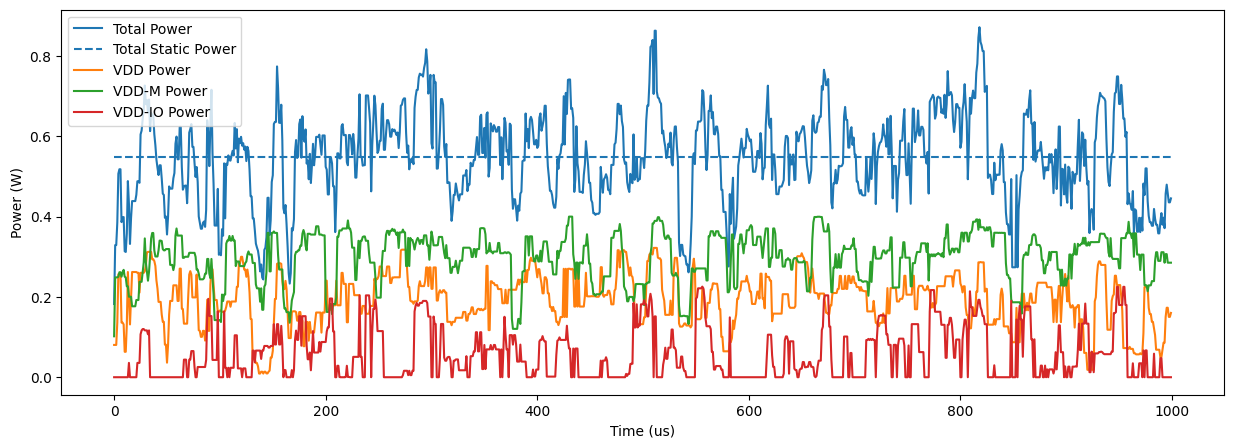

In [17]:
fig, ax = plt.subplots(figsize=(15, 5))
color = next(ax._get_lines.prop_cycler)['color']
ax.plot(total_power, color=color, label='Total Power')
ax.plot(np.zeros_like(total_power)
        + static_total_power,
        linestyle='--', color=color, label='Total Static Power')
color = next(ax._get_lines.prop_cycler)['color']
ax.plot(vdd_p, color=color, label='VDD Power')
color = next(ax._get_lines.prop_cycler)['color']
ax.plot(vddm_p, color=color, label='VDD-M Power')
color = next(ax._get_lines.prop_cycler)['color']
ax.plot(vddio_p, color=color, label='VDD-IO Power')
ax.set_ylabel('Power (W)')
ax.set_xlabel('Time (us)')
ax.legend();

## Activity Results

The activity profiler measures the Loihi 2 neurocore activity metrics such as synaptic operations (`syn_ops`), neuron_updates (`dendrite_updates`), input spikes (`spikes_in`), output spikes (`axon_out`). and more.

The activity metrics provide information about the bottlenecks in each cores and provide intution on where the netowrk and it's mapping can be improved.

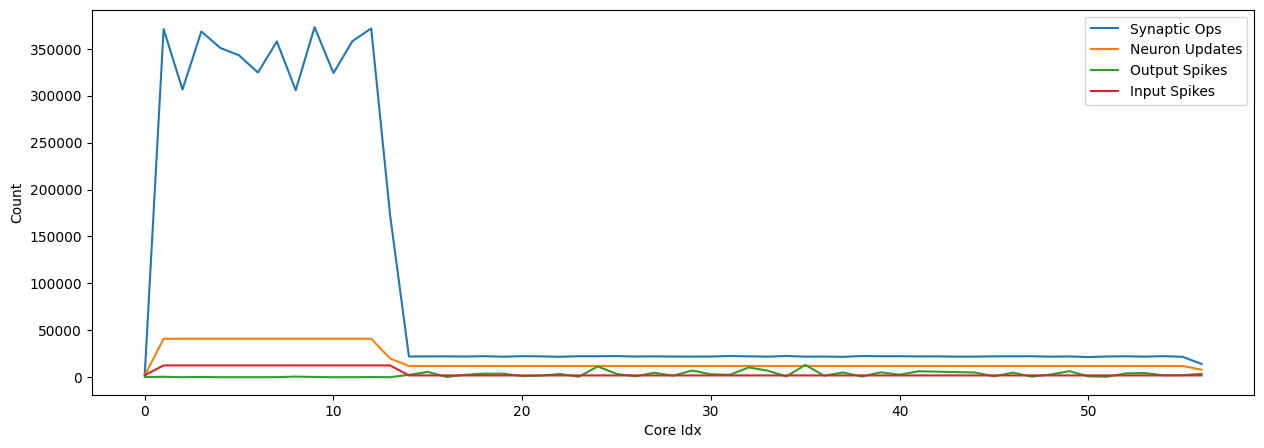

In [18]:
plt.figure(figsize=(15, 5))
plt.plot(activity_logger.core_idx, activity_logger.syn_ops, label='Synaptic Ops')
plt.plot(activity_logger.core_idx, activity_logger.dendrite_updates, label='Neuron Updates')
plt.plot(activity_logger.core_idx, activity_logger.axon_out, label='Output Spikes')
plt.plot(activity_logger.core_idx, activity_logger.spikes_in, label='Input Spikes')
plt.xlabel('Core Idx')
plt.ylabel('Count')
plt.legend()

## Memory Results

The memory profiler mesasures the memory utilization of the individual Loihi cores. This gives an idea of how compactly the network is mapped to the Loihi 2 chip.

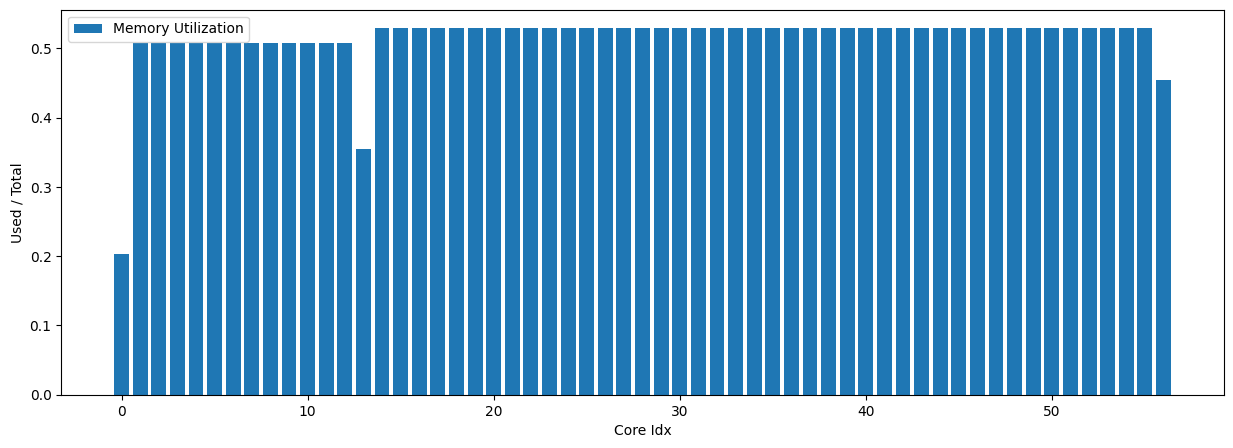

In [19]:
plt.figure(figsize=(15, 5))
plt.bar(memory_logger.core_idx, memory_logger.total_mpds, label='Memory Utilization')
plt.ylabel('Used / Total')
plt.xlabel('Core Idx')
plt.legend();